# Curve Fitting with LMfit


## Libraries and Functions

We start our notebook by:

- Importing all necessary libraries,
- Setting default parameters (mainly for plotting), and
- Defining two useful functions.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%config InlineBackend.figure_format = 'retina'

from lmfit import Model
import scipy.stats as stats

label_size = 18
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 3  # tick labels should be smaller than axes labels (by 3 in our case)
plt.rcParams['ytick.labelsize'] = label_size - 3
plt.rcParams['legend.fontsize'] = label_size - 2
plt.rcParams['legend.frameon'] = False
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

Curve fitting requires that we define the function that maps examples of inputs to outputs. We know from the task description that both peaks have a [Lorentzian lineshape](https://en.wikipedia.org/wiki/Cauchy_distribution).

Therefore, we define one function that returns a Lorentzian peak for a given amplitude (amp), center (cen) and HWHM (gamma) in a given x-range (x). The second function ('Douple_Lorentzian') uses the first one to return two peaks, each with its own characteristics.

In [2]:
def Lorentzian(x, amp, cen, gamma):
    return amp*gamma/(np.pi*( (x - cen)**2 + gamma**2 ))

def Douple_Lorentzian(x, amp1, cen1, gamma1, amp2, cen2, gamma2):
    return Lorentzian(x, amp1, cen1, gamma1) +\
           Lorentzian(x, amp2, cen2, gamma2)

## Creating Data

Let's create the spectrum for our imaginary material.

In [3]:
np.random.seed(1)

# x-axis: 150 evenly spaced numbers between 400 and 406.
x = np.linspace(400, 406, 150)

# y-axis: two Lorentzian peaks + random noise
y_clean = Douple_Lorentzian(x, 1.54, 402.2, 0.34, 
                               1.00, 403.7, 0.65)
y = y_clean + 0.05*np.random.normal(0, 1, 150)

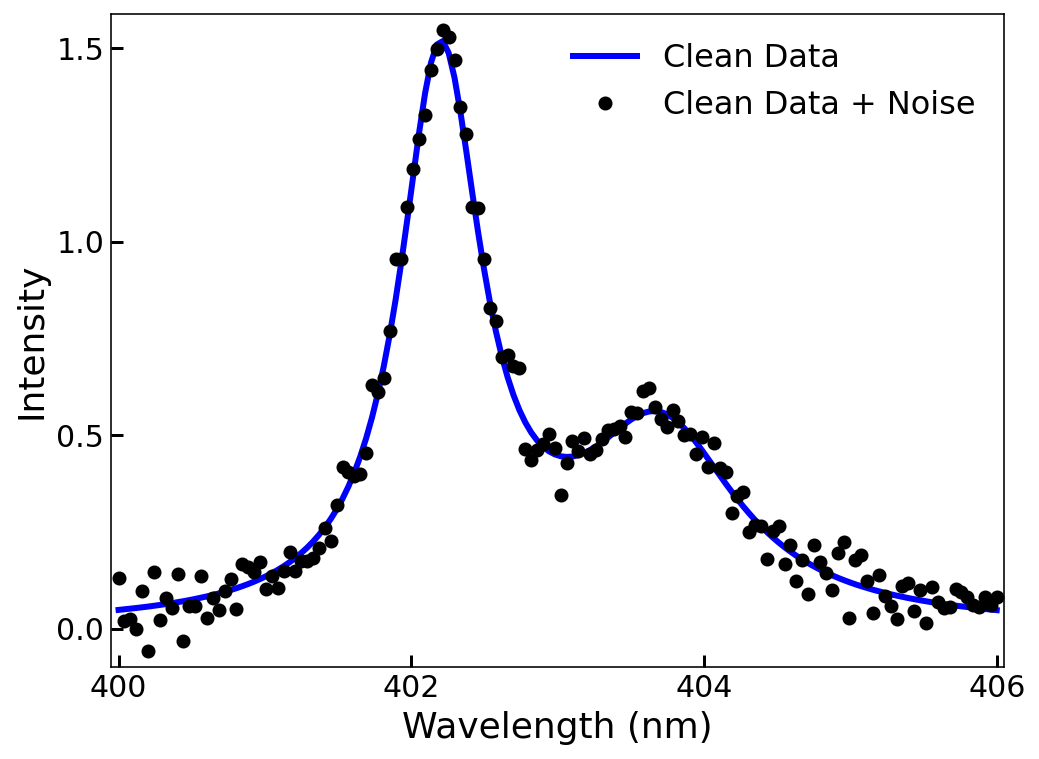

In [4]:
fig = plt.figure(figsize = (8, 6))

plt.plot(x, y_clean, color = 'b', label = 'Clean Data')
plt.plot(x, y, color = 'k', marker = 'o', linestyle = '', label = 'Clean Data + Noise')

plt.xlabel('Wavelength (nm)')
plt.xlim([399.95, 406.05])
plt.xticks([400, 402, 404, 406])

plt.ylabel('Intensity')
plt.ylim([y.min() - 0.04, y.max() + 0.04])
plt.yticks([0, 0.50, 1.00, 1.50])

plt.legend(loc = 0);

Notice that the second peak (circa 404 nm) has a smaller amplitude and broader linewidth than the first one. Also, owing to their spectral proximity and characteristics, the two peaks overlap around ~403 nm.

Random noise is added to simulate real experimental conditions.

## Curve Fitting

We are ready to fit our spectrum. I have organised this process into five steps (for a more detailed description, please see [here](https://lmfit-py.readthedocs.io/_/downloads/en/0.9.4/pdf/)).

In [5]:
# Step 1: Create a model from the user-supplied function 'Double_Lorentzian'
model = Model(Douple_Lorentzian)  

# Step 2: Set parameter hints (initial value and min-max constraints)
model.set_param_hint('amp1', value = 1.50, min = 1.2, max = 1.75)
model.set_param_hint('cen1', value = 402.4, min = 402, max = 402.6)
model.set_param_hint('gamma1', value = 0.30, min = 0.2, max = 0.5)
model.set_param_hint('amp2', value = 0.60, min = 0.40, max = 1.2)
model.set_param_hint('cen2', value = 403.7, min = 403.2, max = 404)
model.set_param_hint('gamma2', value = 0.50, min = 0.30, max = 0.75)

# Step 3: Generate parameters with the expected values
params = model.make_params()

# Step 4: Fit data to this model with the 'param' object
result = model.fit(y, params, x = x)

# Step 5: Extract and display the best values for each parameter along with R^{2}
slope, intercept, r_value, p_value, std_err = stats.linregress(y, result.best_fit)
data_dic = {'Parameters': ['R-squared', 'amp1', 'cen1', 'gamma1', 'amp2', 'cen2', 'gamma2'], 
            'Value': [r_value**2, result.params['amp1'].value, result.params['cen1'].value, result.params['gamma1'].value, result.params['amp2'].value, result.params['cen2'].value, result.params['gamma2'].value], 
            'Errors': ['-', result.params['amp1'].stderr, result.params['cen1'].stderr, result.params['gamma1'].stderr, result.params['amp2'].stderr, result.params['cen2'].stderr, result.params['gamma2'].stderr]}

pd.DataFrame(data_dic)

,Parameters,Value,Errors
0,R-squared,0.986,-
1,amp1,1.572,0.0283
2,cen1,402.204,0.00428
3,gamma1,0.344,0.00716
4,amp2,0.987,0.0375
5,cen2,403.701,0.0183
6,gamma2,0.633,0.0296


## Plotting the Results

The coefficient of determination (R-squared) has a high value (~ 99%), which indicates that our fit is good. However, we have to be careful because [high R-squared values are not always great](https://statisticsbyjim.com/regression/interpret-r-squared-regression/).

There are other ways of assessing the appropriateness of a model. Firstly, we can visually inspect the goodness of the fit by plotting the data along with the fitted curve (individual Lorentzian peaks are also included for clarity).

In [6]:
L1 = Lorentzian(x, result.params['amp1'].value, result.params['cen1'].value, result.params['gamma1'].value)
L2 = Lorentzian(x, result.params['amp2'].value, result.params['cen2'].value, result.params['gamma2'].value)

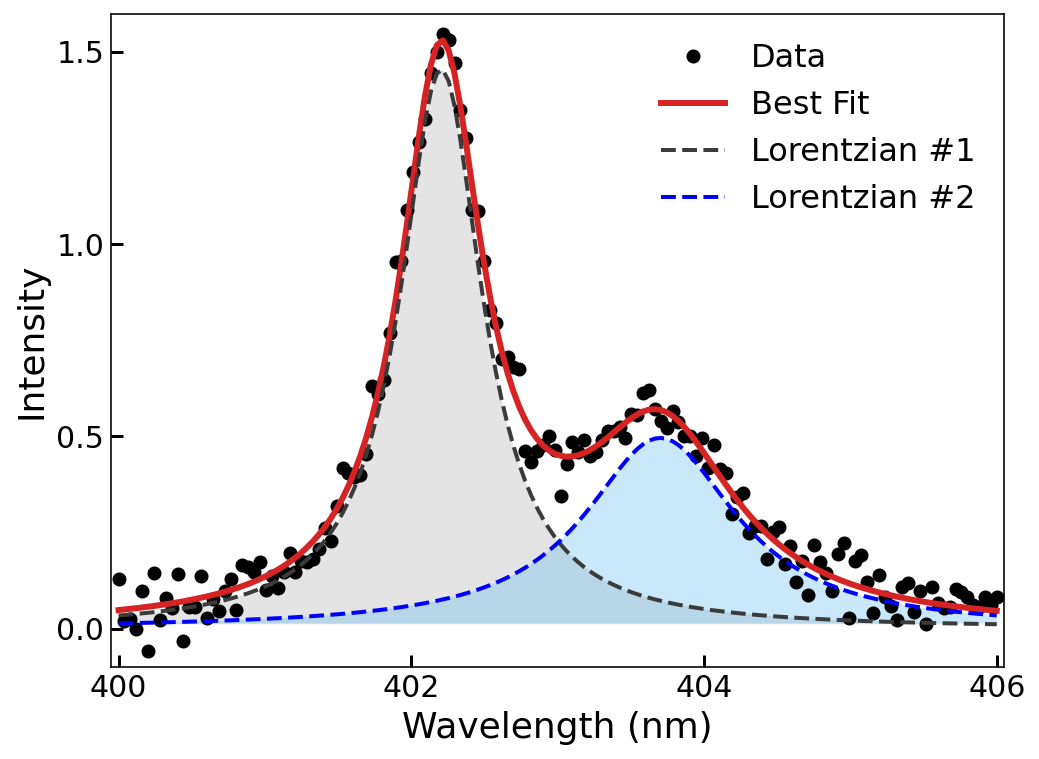

In [7]:
fig = plt.figure(figsize = (8, 6))

plt.plot(x, y, 'ko', label = 'Data')
# plt.plot(x, result.init_fit, color = 'orange', label = 'Init Fit')
plt.plot(x, result.best_fit, color = '#D62424', label = 'Best Fit')

plt.plot(x, L1, color = '#3B3B3B', linestyle = '--', lw = 2, label = 'Lorentzian #1')
plt.fill_between(x, L1.min(), L1, facecolor = '#A8A8A8', alpha = 0.3) 
plt.plot(x, L2, 'b--', lw = 2, label = 'Lorentzian #2')
plt.fill_between(x, L2.min(), L2, facecolor = '#4FB6F1', alpha = 0.3) 

plt.xlabel('Wavelength (nm)')
plt.xlim([399.95, 406.05])
plt.xticks([400, 402, 404, 406])

plt.ylabel('Intensity')
plt.ylim([y.min() - 0.04, y.max() + 0.05])
plt.yticks([0, 0.50, 1.00, 1.50])

plt.legend(loc = 0);
# plt.savefig('Figure.svg');

The goodness of fit is impressive. Additionally, plotting residuals is another reliable way of assessing our model.

### Residual Plot

Simply put, a residual is the difference between the observed value and the predicted value of the dependent variable. As the name suggests, a residual plot is a scatter plot of residuals on the vertical axis and the independent variable on the horizontal axis.

If the points in a residual plot are randomly scattered around zero, our model is appropriate for the data. On the other hand, if there is a pattern in the residual plot, our model does not provide an adequate fit for the data. 

Visualizing a residual plot in Python is quite straightforward:

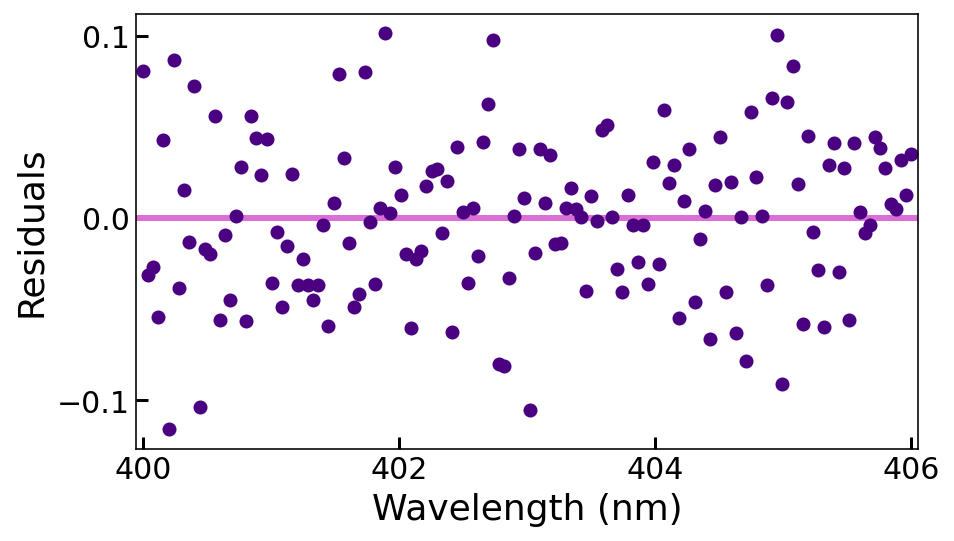

In [8]:
fig = plt.figure(figsize = (7, 4))

plt.axhline(y = 0, color = 'orchid', linestyle = '-')
plt.plot(x, y - result.best_fit, color = 'indigo', marker = 'o', linestyle = '', label = 'Data')

plt.xlabel('Wavelength (nm)')
plt.xlim([399.95, 406.05])
plt.xticks([400, 402, 404, 406])

plt.ylabel('Residuals')
plt.yticks([-0.10, 0, 0.10]);

Residuals are randomly dispersed around zero (horizontal line), which confirms what our model is fitting the data well.

We can merge the last two plots into one by using matplotlib's `gridspec` (all credits go to [Emily](http://www.emilygraceripka.com/blog/16)):

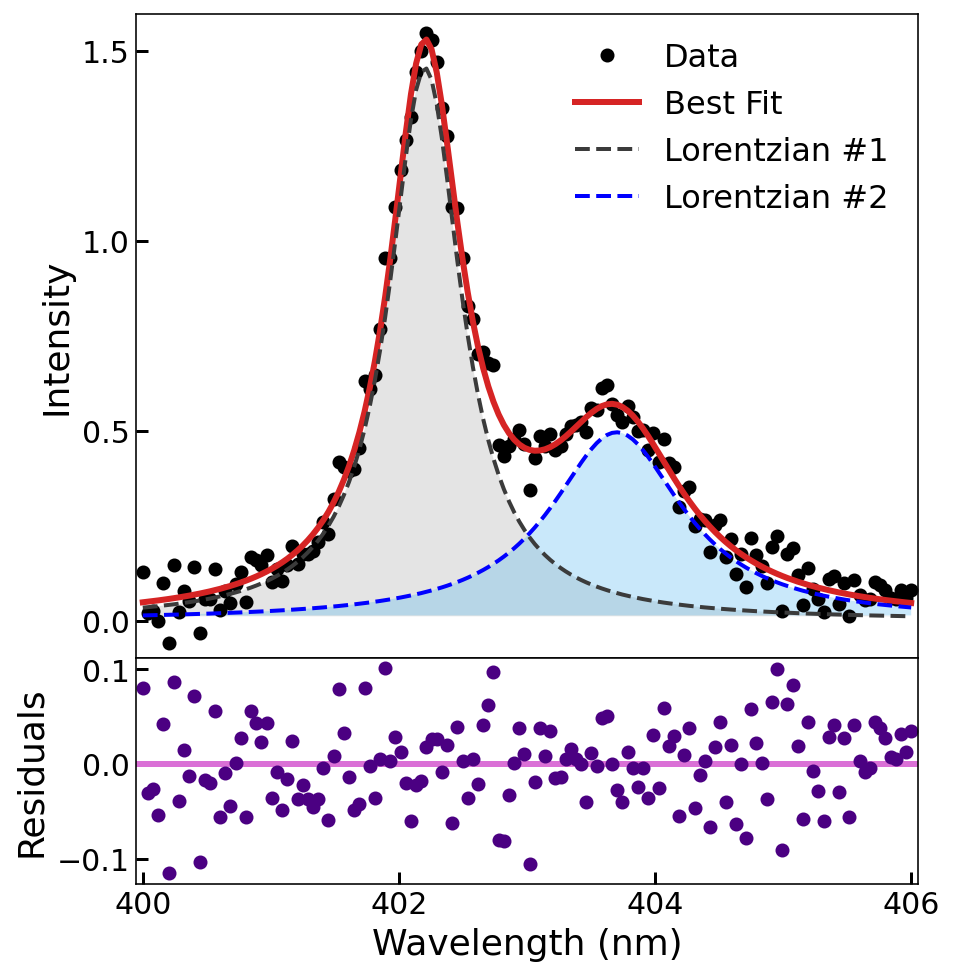

In [9]:
fig = plt.figure(figsize = (7, 8))
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 0.35])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace = 0) 

#### Plotting data + fits
ax1.plot(x, y, 'ko', label = 'Data')
ax1.plot(x, result.best_fit, color = '#D62424', label = 'Best Fit')

ax1.plot(x, L1, color = '#3B3B3B', linestyle = '--', lw = 2, label = 'Lorentzian #1')
ax1.fill_between(x, L1.min(), L1, facecolor = '#A8A8A8', alpha = 0.3) 
ax1.plot(x, L2, 'b--', lw = 2, label = 'Lorentzian #2')
ax1.fill_between(x, L2.min(), L2, facecolor = '#4FB6F1', alpha = 0.3) 

ax1.set_xlim([399.95, 406.05])
ax1.set_xticks([]);
ax1.set_ylim([y.min() - 0.04, y.max() + 0.05])
ax1.set_ylabel('Intensity')
ax1.set_yticks([0, 0.50, 1.00, 1.50])
ax1.legend(loc = 0)

#### Plotting residuals
ax2.axhline(y = 0, color = 'orchid', linestyle = '-')
ax2.plot(x, y - result.best_fit, color = 'indigo', marker = 'o', linestyle = '', label = 'Data')

ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim([399.95, 406.05])
ax2.set_ylabel('Residuals')
ax2.set_xticks([400, 402, 404, 406]);

# plt.savefig('Final_Figure.svg');

For the sake of completeness, I have to mention that lmfit has a `fit_report` function for showing the fit statistics, variables, and correlations. I prefer the pandas dataframe we created earlier.

In [10]:
from lmfit import fit_report

print(fit_report(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 150
    # variables        = 6
    chi-square         = 0.28561636
    reduced chi-square = 0.00198345
    Akaike info crit   = -927.561160
    Bayesian info crit = -909.497348
[[Variables]]
    amp1:    1.57180646 +/- 0.02825266 (1.80%) (init = 1.5)
    cen1:    402.204169 +/- 0.00428035 (0.00%) (init = 402.4)
    gamma1:  0.34396731 +/- 0.00716041 (2.08%) (init = 0.3)
    amp2:    0.98709225 +/- 0.03748789 (3.80%) (init = 0.6)
    cen2:    403.700657 +/- 0.01833447 (0.00%) (init = 403.7)
    gamma2:  0.63336949 +/- 0.02962349 (4.68%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp2, gamma2)   =  0.832
    C(amp1, gamma1)   =  0.817
    C(amp1, amp2)     = -0.717
    C(amp1, gamma2)   = -0.597
    C(gamma1, amp2)   = -0.558
    C(amp1, cen2)     =  0.451
    C(gamma1, gamma2) = -0.419
    C(gamma1, cen2)   =  0.356
    C(amp2, cen2)     = -0.336
    C(